In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
from sklearn import gaussian_process as gp
import statsmodels.api as sm
from scipy import stats as st

Shorthand:

* `y_rt`: Interior/Exterior branch length ratio of the transmission tree.
* `y_rm`: Interior/Exterior branch length ratio of the phylogeny. (not randomized lengths, but topology is shuffled)
* `y_rtm`: Interior/Exterior branch length ratio of mutation rescaled & sampled transmission tree.
* `y_rmm`: Interior/Exterior branch length ratio of mutation rescaled & sampled phylogeny.
    

In [3]:
data = pd.read_csv('../RealData/Clean/SEEPS_Simulation_1.csv')

In [4]:
label_dict = {}
label_dict["y_rt"] = "Time scaled tranmission tree I/E ratio"
label_dict["y_rm"] = "Time scaled phylogenty I/E ratio"
label_dict["y_rtm"] = "Sampled mutation scaled transmission tree I/E ratio"
label_dict["y_rmm"] = "Sampled mutation scaled phylogeny I/E ratio"

In [5]:
label_dict_2line = {}
label_dict_2line["y_rt"] = "Time scaled\ntranmission tree\nI/E ratio"
label_dict_2line["y_rm"] = "Time scaled\nphylogenty\nI/E ratio"
label_dict_2line["y_rtm"] = "Sampled mutation\nscaled transmission tree\nI/E ratio"
label_dict_2line["y_rmm"] = "Sampled mutation\nscaled phylogeny\nI/E ratio"

In [6]:
data.head()

,tau,p,MaxPop,R0,y_rt,y_rm,y_rtm,y_rmm
0,0.0,0.1,6886.937531,4.980320,0.322242,0.183073,0.487589,0.263410
1,0.0,0.1,3178.598279,2.432326,0.431214,0.277591,0.289352,0.320513
2,0.0,0.1,1009.790488,1.680147,0.394737,0.209549,0.322997,0.285218
3,0.0,0.1,1123.805265,2.716167,0.343947,0.228953,0.322770,0.163399
4,0.0,0.1,3127.099807,4.711149,0.308333,0.246756,0.457317,0.234742


In [7]:
X = data.iloc[:, 4:].values
X2 = data.iloc[:,:].values

In [8]:
X_means = np.mean(X, axis=0)
X_means2 = np.mean(X2, axis=0)
Xs = X - X_means
cov = np.cov(Xs.T)
cov2 = np.cov((X2 - X_means2).T)

In [9]:
cc2 = np.corrcoef(X2.T)

In [10]:
indexes = [0,1,4,5,6,7]
c2 = cov2[:,indexes][indexes]

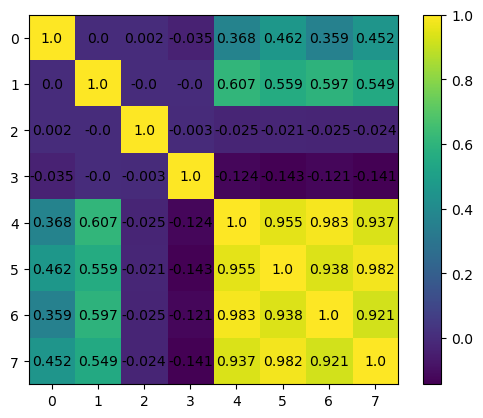

In [11]:
plt.imshow(cc2, interpolation='nearest')
plt.colorbar()
# Put the plot value in each cell
for i in range(8):
    for j in range(8):
        plt.text(j, i, round(cc2[i, j], 3), ha='center', va='center', color='black')
plt.show()

In [12]:
data.head()

,tau,p,MaxPop,R0,y_rt,y_rm,y_rtm,y_rmm
0,0.0,0.1,6886.937531,4.980320,0.322242,0.183073,0.487589,0.263410
1,0.0,0.1,3178.598279,2.432326,0.431214,0.277591,0.289352,0.320513
2,0.0,0.1,1009.790488,1.680147,0.394737,0.209549,0.322997,0.285218
3,0.0,0.1,1123.805265,2.716167,0.343947,0.228953,0.322770,0.163399
4,0.0,0.1,3127.099807,4.711149,0.308333,0.246756,0.457317,0.234742


0.08 0.04 0.08 0.04 0.04 0.03 0.04 0.03 0.08 0.04 0.08 0.04 0.04 0.03 0.04 0.03 

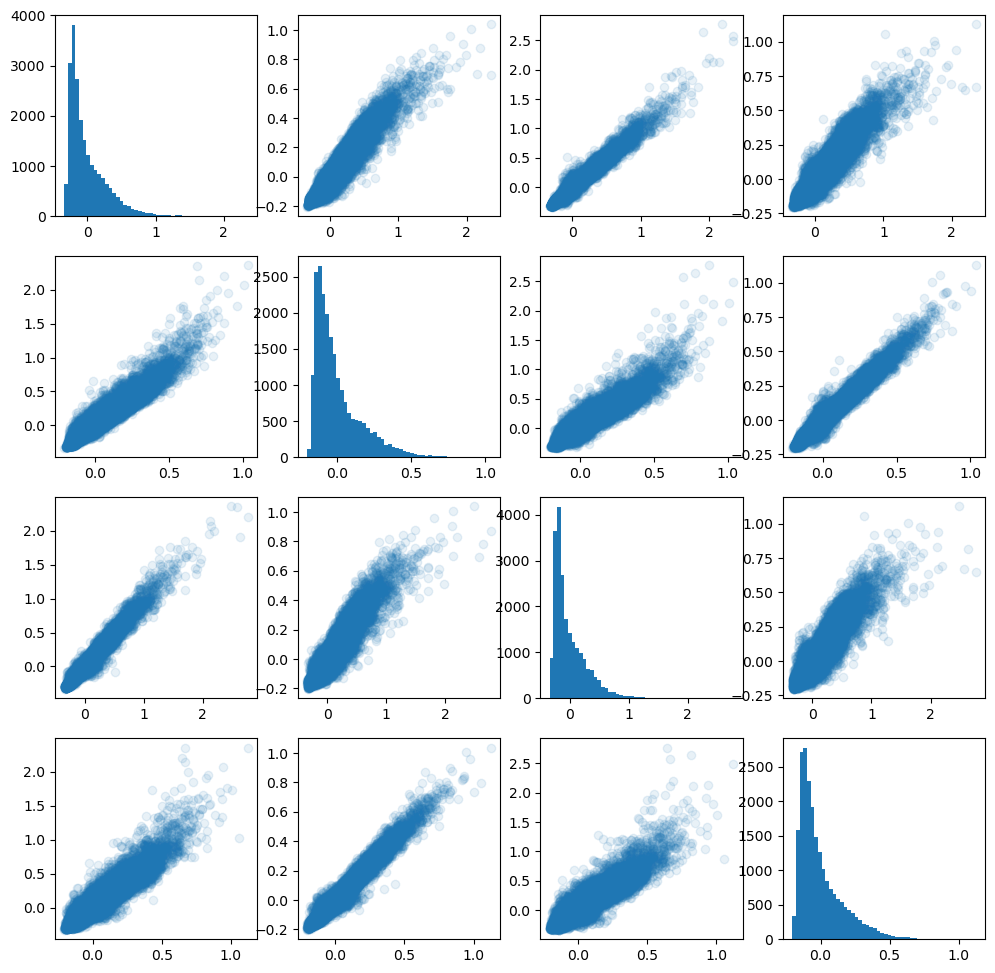

In [13]:
fig, ax = plt.subplots(4,4, figsize=(12, 12))
for i in range(4):
    for j in range(4):
        print(f'{cov[i, j]:.2f}', end=' ')
        if i == j:
            ax[i,j].hist(Xs[:, i], bins=50)
        else:
            ax[i,j].scatter(Xs[:, i], Xs[:, j], alpha=0.1)

## Each trial gives the same pattern

In [14]:
data

,tau,p,MaxPop,R0,y_rt,y_rm,y_rtm,y_rmm
0,0.0,0.1,6886.937531,4.980320,0.322242,0.183073,0.487589,0.263410
1,0.0,0.1,3178.598279,2.432326,0.431214,0.277591,0.289352,0.320513
2,0.0,0.1,1009.790488,1.680147,0.394737,0.209549,0.322997,0.285218
3,0.0,0.1,1123.805265,2.716167,0.343947,0.228953,0.322770,0.163399
4,0.0,0.1,3127.099807,4.711149,0.308333,0.246756,0.457317,0.234742
...,...,...,...,...,...,...,...,...
21995,120.0,0.9,1580.832236,4.549277,0.810383,0.534732,0.806726,0.542791
21996,120.0,0.9,4367.228541,4.802316,0.504583,0.293443,0.444067,0.351658
21997,120.0,0.9,1073.323117,4.229607,1.263874,0.601937,1.305970,0.602343
21998,120.0,0.9,1534.430524,4.391057,0.575383,0.426020,0.648051,0.449811


In [15]:
p_values = np.unique(data["p"].values)
p_values = np.sort(p_values)
p_values = np.flip(p_values)
tau_values = np.unique(data["tau"].values)
tau_values = np.sort(tau_values)

In [16]:
keys = ["y_rt", "y_rm", "y_rtm", "y_rmm"]

In [17]:
model_dict = {}

In [18]:
plotting_grid = np.linspace(np.min(data["R0"]), np.max(data["R0"]), 300)
preds_all = {}

preds_exact = {}

for key in keys:
    # fig, ax = plt.subplots(2, 11, figsize=(24, 6), sharey=True)
    print(key)
    for pdx, p in enumerate(p_values):
        data_subset = data[data["p"] == p]
        for i, t in enumerate(tau_values):
            ds2 = data_subset[data_subset["tau"] == t]
            x = ds2["R0"].values
            y = ds2[key].values

            kernel = gp.kernels.RBF(length_scale=3, length_scale_bounds="fixed")
            model = gp.GaussianProcessRegressor(alpha=1e-4, kernel=kernel)
            model.fit(x.reshape(-1, 1), y)
            yp, ystd = model.predict(plotting_grid.reshape(-1, 1), return_std=True)
            preds_exact[(p, t, key)] = (x, y, model.predict(x.reshape(-1, 1), return_std=False))
            # ax[pdx, i].scatter(x, y, alpha=0.1)
            # ax[pdx, i].plot(plotting_grid, yp, color="red")
            model_dict[(p, t, key)] = model
            preds_all[(p, t, key)] = (plotting_grid, yp, ystd)
            # if pdx == 1:
            #     ax[pdx, i].set_xlabel(r"$R_0$")
            # if i == 0:
                # ax[pdx, 0].set_ylabel(key)
    plt.show()

y_rt
y_rm
y_rtm
y_rmm


In [19]:
keys1 = ["y_rt", "y_rtm"]
keys_other = [key for key in keys if key in keys and key != "y_rt"]

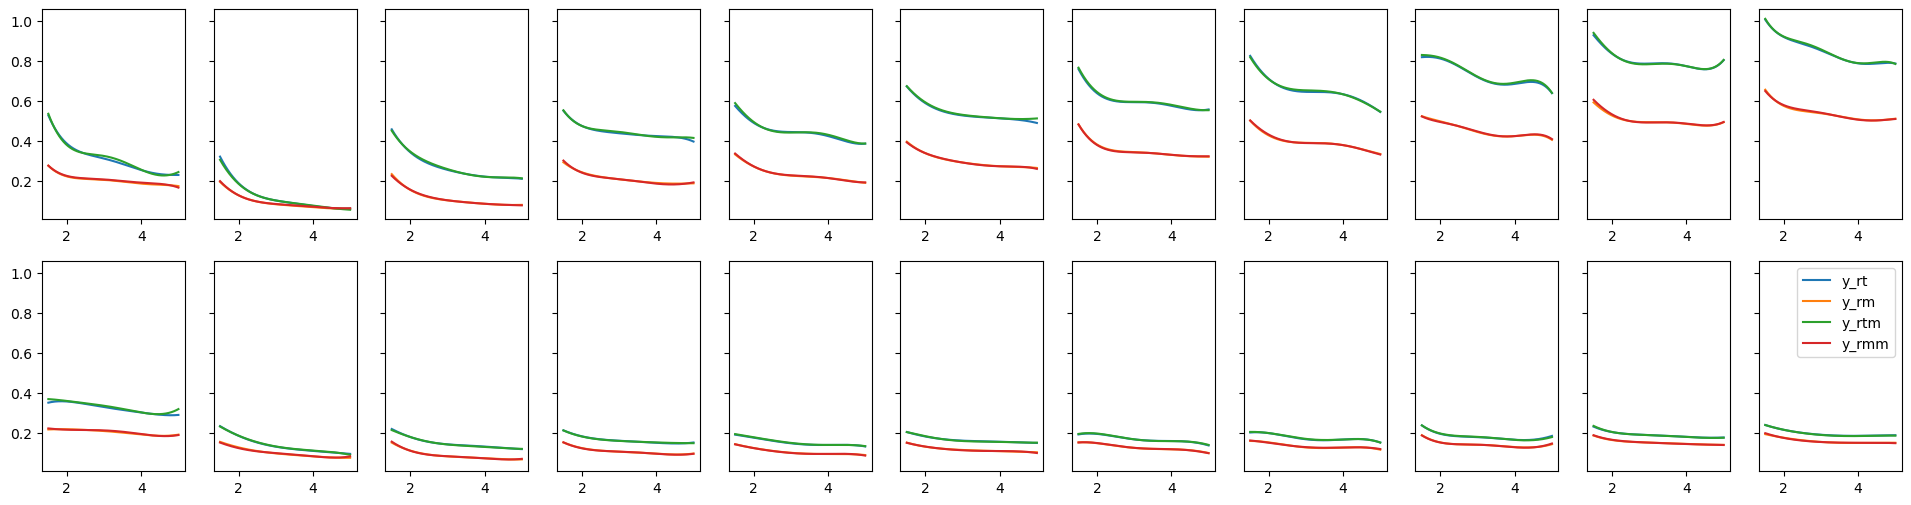

In [20]:
fig, ax = plt.subplots(2, 11, figsize=(24, 6), sharey=True)
    # fig, ax = plt.subplots(2, 11, figsize=(24, 6), sharey=True)
for pdx, p in enumerate(p_values):
    for i, t in enumerate(tau_values):
        for key in keys:
            x, yp, ystd = preds_all[(p, t, key)]
            ax[pdx, i].plot(x, yp, label=key)
            # ax[pdx,i].set_yscale("log")
            # ax[pdx, i].fill_between(x, yp - ystd, yp + ystd, alpha=0.3)
ax[-1,-1].legend()

# Compare y_rt vs the other keys
for key in keys_other:
    fig, ax = plt.subplots(2, 11, figsize=(24, 6), sharey=True)
    for pdx, p in enumerate(p_values):
        for i, t in enumerate(tau_values):
            x, yp, ystd = preds_all[(p, t, key)]
            x_ref, yp_ref, ystd_ref = preds_all[(p, t, "y_rt")]
            ax[pdx, i].plot(x, yp-yp_ref, label=key)
            # ax[pdx, i].set_ylim(-0.5, 0.5)
            # ax[pdx,i].set_yscale("log")
            # ax[pdx, i].fill_between(x, yp - ystd, yp + ystd, alpha=0.3)
    ax[-1,-1].legend()

# Compare y_rt vs the other keys
for key in keys_other:
    fig, ax = plt.subplots(2, 11, figsize=(24, 6), sharey=True)
    for pdx, p in enumerate(p_values):
        for i, t in enumerate(tau_values):
            x, yp, ystd = preds_all[(p, t, key)]
            data_subset = data[(data["p"] == p) & (data["tau"] == t)]
            x_ref, yp_ref, ystd_ref = preds_all[(p, t, "y_rt")]
            ax[pdx, i].scatter(yp,yp_ref, c=x, alpha=0.5)
            # ax[pdx, i].set_ylim(-0.5, 0.5)
            # ax[pdx,i].set_yscale("log")
            # ax[pdx, i].fill_between(x, yp - ystd, yp + ystd, alpha=0.3)
    ax[-1,-1].legend()

In [21]:
data_subset.head()

,tau,p,MaxPop,R0,y_rt,y_rm,y_rtm,y_rmm
0,0.0,0.1,6886.937531,4.980320,0.322242,0.183073,0.487589,0.263410
1,0.0,0.1,3178.598279,2.432326,0.431214,0.277591,0.289352,0.320513
2,0.0,0.1,1009.790488,1.680147,0.394737,0.209549,0.322997,0.285218
3,0.0,0.1,1123.805265,2.716167,0.343947,0.228953,0.322770,0.163399
4,0.0,0.1,3127.099807,4.711149,0.308333,0.246756,0.457317,0.234742


# Compare y_rt vs the other keys

for key in keys_other:
    fig, ax = plt.subplots(2, 11, figsize=(24, 6), sharey=True, sharex=True)
    for pdx, p in enumerate(p_values):
        for i, t in enumerate(tau_values):
            data_subset = data[(data["p"] == p) & (data["tau"] == t)]
            y_key = data_subset[key].values
            y_ref = data_subset["y_rt"].values
            ax[pdx,i].scatter(y_key, y_ref, c=data_subset["R0"], alpha=0.5, s=2)
            ax[pdx,i].set_title(f"p={p}, tau={t}")
            ax[pdx,i].plot([0, 1], [0, 1], transform=ax[pdx,i].transAxes)

            # ax[pdx, i].scatter(yp,yp_ref, c=x, alpha=0.5)

    ax[-1,-1].legend()

## Conditional correlation analysis

In [22]:
import seaborn as sns

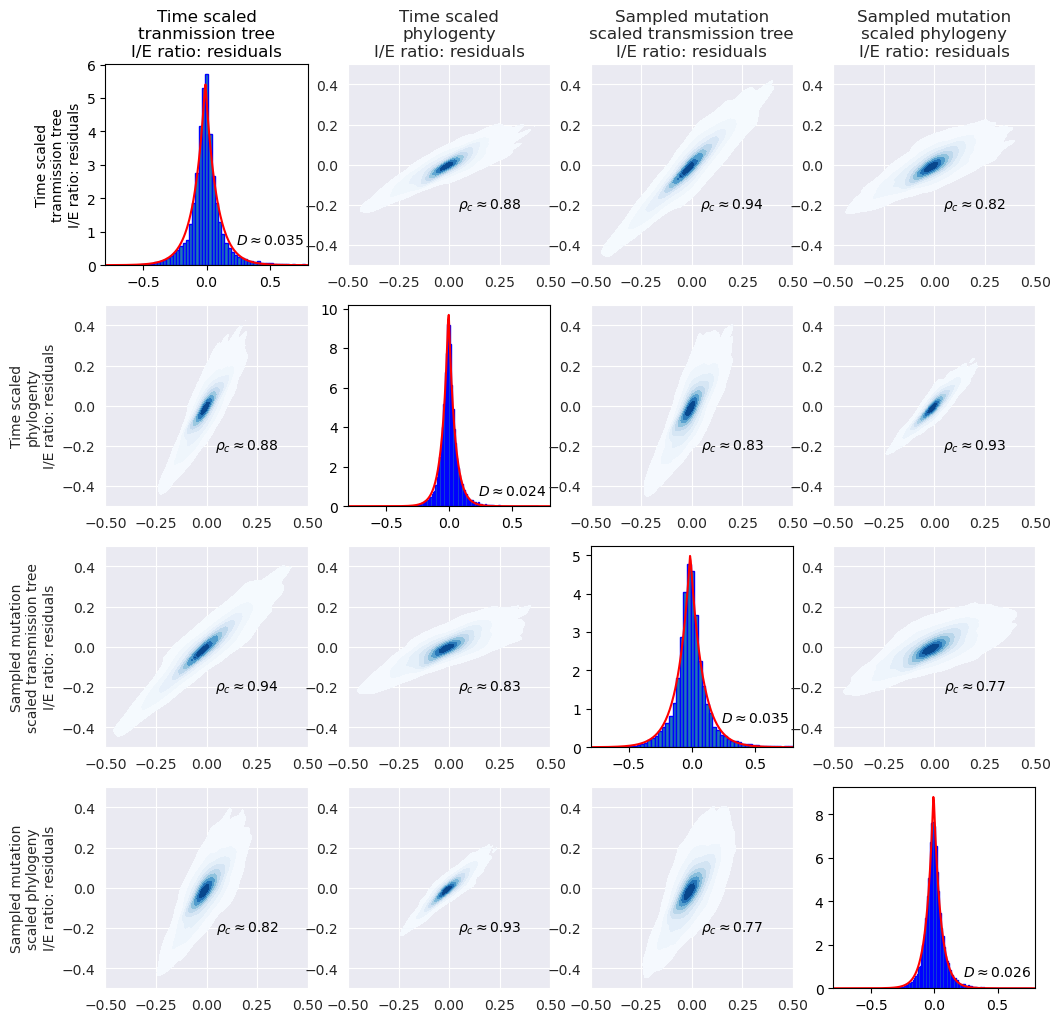

In [76]:
ymin = -0.5
ymax = 0.5

hist_min = -0.8
hist_max = 0.8

plotting_fine = np.linspace(hist_min, hist_max, 300)

# fig, ax = plt.subplots(4, 4, figsize=(12, 12))
fig = plt.figure(figsize=(12, 12))
gs = fig.add_gridspec(4, 4)
ax = np.empty((4, 4), dtype=object)
# First, setup the figure
for i in range(len(keys)):
    for j in range(len(keys)):
        if i == j:
            # with sns.axes_style("white"):
            ax[i, j] = fig.add_subplot(gs[i, j])
        else:  # i != j
            with sns.axes_style("darkgrid"):
                ax[i, j] = fig.add_subplot(gs[i, j])


for idx, key1 in enumerate(keys):
    for jdx, key2 in enumerate(keys):
        x_all = []
        resids_all_1 = []
        resids_all_2 = []
        for pdx, p in enumerate(p_values):
            for i, t in enumerate(tau_values):
                x1, y1, ypred1 = preds_exact[(p, t, key1)]
                x2, y2, ypred2 = preds_exact[(p, t, key2)]
                resids1 = y1 - ypred1
                resids2 = y2 - ypred2
                resids_all_1.append(resids1)
                resids_all_2.append(resids2)
        resids1 = np.concatenate(resids_all_1)
        resids2 = np.concatenate(resids_all_2)
        # calculate the correlation
        corr = np.corrcoef(resids1, resids2)
        # Print the correlation on the plot
        if idx != jdx:
            # ax[idx,jdx].hist2d(resids1, resids2, bins=100, cmap="gray_r")
            sns.kdeplot(x=resids1, y=resids2, ax=ax[idx,jdx], cmap="Blues", fill=True)
            ax[idx,jdx].text(0.2, -0.2, fr'$\rho_c \approx {corr[0,1]:.2f}$', ha='center', va='center', color='black')
            ax[idx,jdx].set_xlim(ymin, ymax)
            ax[idx,jdx].set_ylim(ymin, ymax)
        else:
            mu, b = st.laplace.fit(resids1)
            rv = st.laplace(mu, b)
            with sns.axes_style("white"):
                ax[idx,jdx].hist(resids1, bins=100, density=True, edgecolor="blue")
                ax[idx, jdx].set_xlim(hist_min, hist_max)
                res = st.kstest(resids1, rv.cdf)
                ax[idx,jdx].text(0.5, 0.75, fr'$D \approx {res.statistic:.3f}$', ha='center', va='center', color='black')
                ax[idx,jdx].plot(plotting_fine, rv.pdf(plotting_fine), color="red")
            # sns.set_style("white")
        if idx == 0:
            ax[idx,jdx].set_title(label_dict_2line[key2] + ": residuals")
        if jdx == 0:
            ax[idx,jdx].set_ylabel(label_dict_2line[key1] + ": residuals")


In [50]:
table_data = {}
table_data[""] = ["Mean", "Variance", r"Laplace $\mu$", r"Laplace $b$"]
for key in keys:
    table_data[label_dict_2line[key]] = []
    residuals = []
    for pdx, p in enumerate(p_values):
        for i, t in enumerate(tau_values):
            x, y, ypred = preds_exact[(p, t, key)]
            resids = y - ypred
            residuals.append(resids)
    # Compute mean
    table_data[label_dict_2line[key]].append(np.mean(residuals))
    # Compute variance|
    table_data[label_dict_2line[key]].append(np.var(residuals))
    # Estimate the Laplace distribution
    mu, b = st.laplace.fit(residuals)
    table_data[label_dict_2line[key]].append(mu)
    table_data[label_dict_2line[key]].append(b)
table_data = pd.DataFrame(table_data)

In [51]:
table_data.update(table_data[[label_dict_2line[key] for key in keys]].applymap('{:,.4e}'.format))

/tmp/ipykernel_2328001/3572398111.py:1: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  table_data.update(table_data[[label_dict_2line[key] for key in keys]].applymap('{:,.4e}'.format))
/tmp/ipykernel_2328001/3572398111.py:1: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '['1.8953e-07' '2.2228e-02' '-9.5459e-03' '9.0964e+01']' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  table_data.update(table_data[[label_dict_2line[key] for key in keys]].applymap('{:,.4e}'.format))
/tmp/ipykernel_2328001/3572398111.py:1: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '['1.3700e-07' '5.5416e-03' '-4.7019e-03' '4.9600e+01']' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  table_data.update(table_data[[label_dict_2line[key] for key in keys]].

In [52]:
table_data

,,Time scaled\ntranmission tree\nI/E ratio,Time scaled\nphylogenty\nI/E ratio,Sampled mutation\nscaled transmission tree\nI/E ratio,Sampled mutation\nscaled phylogeny\nI/E ratio
0,Mean,1.8953e-07,1.3700e-07,1.9988e-07,1.3953e-07
1,Variance,2.2228e-02,5.5416e-03,2.5320e-02,6.4947e-03
2,Laplace $\mu$,-9.5459e-03,-4.7019e-03,-1.1954e-02,-6.2224e-03
3,Laplace $b$,9.0964e+01,4.9600e+01,9.8927e+01,5.5024e+01


# Final version!

In [53]:
key_list_1 = ["y_rt", "y_rm"]
key_list_2 = ["y_rtm", "y_rmm"]

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


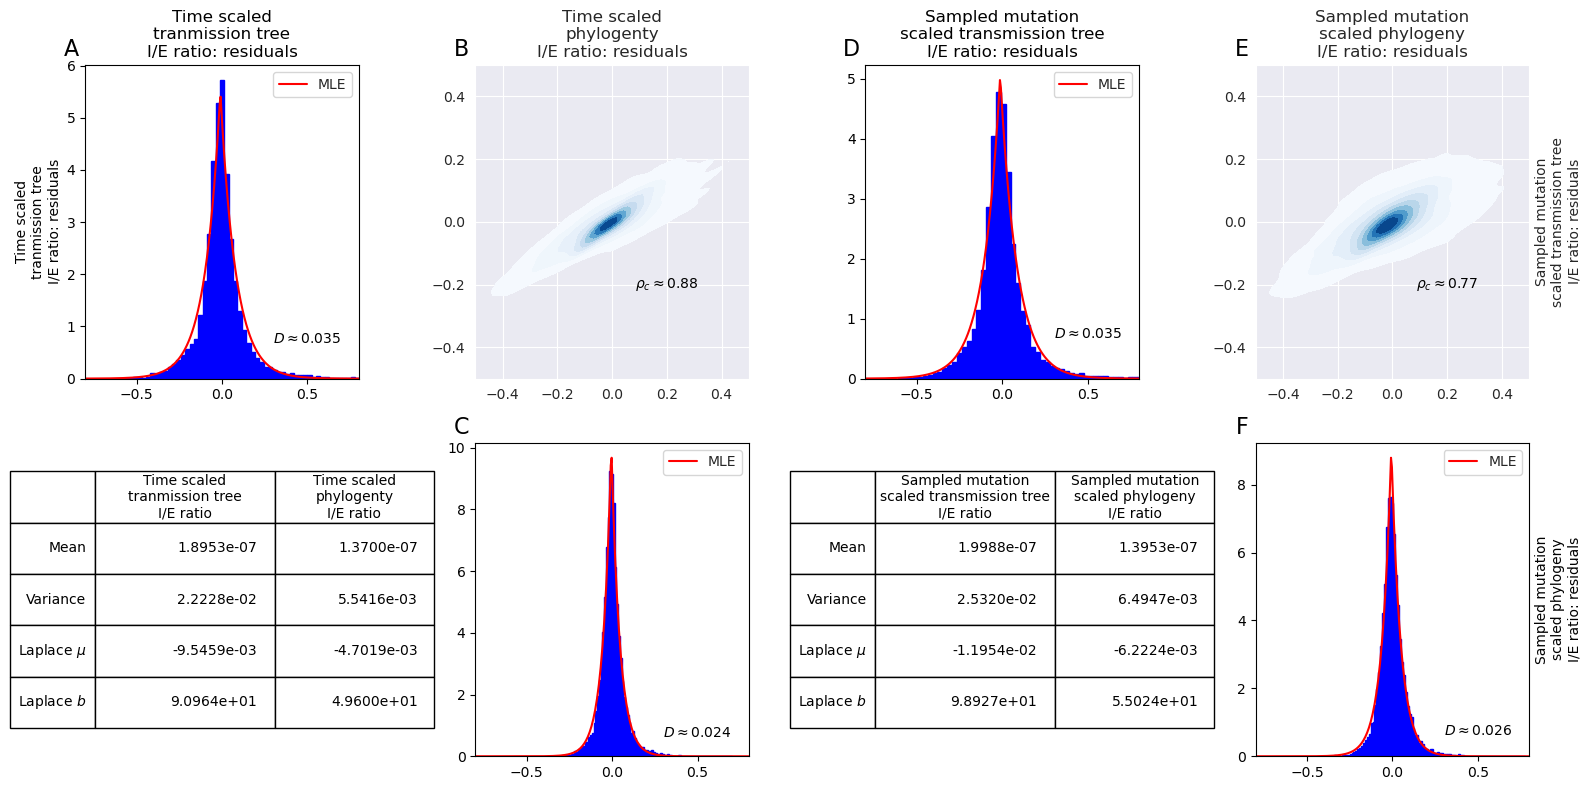

In [75]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as st
import pandas as pd

ymin = -0.5
ymax = 0.5

hist_min = -0.8
hist_max = 0.8

plotting_fine = np.linspace(hist_min, hist_max, 300)

fig = plt.figure(figsize=(16, 8))
gs = fig.add_gridspec(2, 4)
ax = np.empty((2, 4), dtype=object)

# Setup the figure
for i in range(2):
    for j in range(4):
        if (i == 0 and j == 1) or (i == 0 and j == 3):
            with sns.axes_style("darkgrid"):
                ax[i, j] = fig.add_subplot(gs[i, j])
        else:
            ax[i, j] = fig.add_subplot(gs[i, j])

letters_1 = "AB C"
letters_2 = "DE F"
# Populate the plots
for idx, key1 in enumerate(key_list_1):
    for jdx, key2 in enumerate(key_list_1):
        # if (idx < 2) and (jdx < 4):
            x_all = []
            resids_all_1 = []
            resids_all_2 = []
            for pdx, p in enumerate(p_values):
                for i, t in enumerate(tau_values):
                    x1, y1, ypred1 = preds_exact[(p, t, key1)]
                    x2, y2, ypred2 = preds_exact[(p, t, key2)]
                    resids1 = y1 - ypred1
                    resids2 = y2 - ypred2
                    resids_all_1.append(resids1)
                    resids_all_2.append(resids2)
            resids1 = np.concatenate(resids_all_1)
            resids2 = np.concatenate(resids_all_2)
            corr = np.corrcoef(resids1, resids2)

            ax[idx,jdx].text(-0.05, 1.05, letters_1[idx*2 + jdx], ha='center', va='center', color='black', transform=ax[idx,jdx].transAxes, fontsize=16)
            if (idx == 0 and jdx == 0) or (idx == 1 and jdx == 1) or (idx == 0 and jdx == 2) or (idx == 1 and jdx == 3):
                # Place a letter on the plot in the top left corner over the plot
                mu, b = st.laplace.fit(resids1)
                rv = st.laplace(mu, b)
                with sns.axes_style("white"):
                    ax[idx,jdx].hist(resids1, bins=100, density=True, edgecolor='blue', color='blue')
                    ax[idx,jdx].set_xlim(hist_min, hist_max)
                    res = st.kstest(resids1, rv.cdf)
                    ax[idx,jdx].text(0.5, 0.75, fr'$D \approx {res.statistic:.3f}$', ha='center', va='center', color='black')
                    ax[idx,jdx].plot(plotting_fine, rv.pdf(plotting_fine), color="red", label="MLE")
                    ax[idx,jdx].legend()
            elif (idx == 0 and jdx == 1) or (idx == 0 and jdx == 3):
                sns.kdeplot(x=resids1, y=resids2, ax=ax[idx,jdx], cmap="Blues", fill=True)
                ax[idx,jdx].text(0.2, -0.2, fr'$\rho_c \approx {corr[0,1]:.2f}$', ha='center', va='center', color='black')
                ax[idx,jdx].set_xlim(ymin, ymax)
                ax[idx,jdx].set_ylim(ymin, ymax)
            elif (idx == 1 and (jdx == 0 or jdx == 2)):
                ax[idx, jdx].axis('off')
                tdata = table_data[[""] + [label_dict_2line[key] for key in key_list_1]]
                table_1 = ax[idx, jdx].table(cellText=tdata.values, colLabels=tdata.columns, loc='center', colWidths = [0.2, 0.425, 0.375])
                table_1.auto_set_font_size(False)
                table_1.set_fontsize(10)
                table_1.scale(1.55, 2.75)
            if idx == 0:
                ax[idx,jdx].set_title(label_dict_2line[key2] + ": residuals")
            if jdx == 0:
                ax[idx,jdx].set_ylabel(label_dict_2line[key1] + ": residuals")
            if jdx == 3:
                ax[idx,jdx].yaxis.set_label_position("right")
                ax[idx,jdx].set_ylabel(label_dict_2line[key1] + ": residuals")

# Second set, keys2
for idx, key1 in enumerate(key_list_2):
    for jdx, key2 in enumerate(key_list_2):
        # if (idx < 2) and (jdx < 4):
            x_all = []
            resids_all_1 = []
            resids_all_2 = []
            for pdx, p in enumerate(p_values):
                for i, t in enumerate(tau_values):
                    x1, y1, ypred1 = preds_exact[(p, t, key1)]
                    x2, y2, ypred2 = preds_exact[(p, t, key2)]
                    resids1 = y1 - ypred1
                    resids2 = y2 - ypred2
                    resids_all_1.append(resids1)
                    resids_all_2.append(resids2)
            resids1 = np.concatenate(resids_all_1)
            resids2 = np.concatenate(resids_all_2)
            corr = np.corrcoef(resids1, resids2)
            ax[idx,jdx+2].text(-0.05, 1.05, letters_2[idx*2 + jdx], ha='center', va='center', color='black', transform=ax[idx,jdx+2].transAxes, fontsize=16)
            jdx += 2
            if  (idx == 0 and jdx == 2) or (idx == 1 and jdx == 3):
                mu, b = st.laplace.fit(resids1)
                rv = st.laplace(mu, b)
                with sns.axes_style("white"):
                    ax[idx,jdx].hist(resids1, bins=100, density=True, edgecolor='blue', color='blue')
                    ax[idx,jdx].set_xlim(hist_min, hist_max)
                    res = st.kstest(resids1, rv.cdf)
                    ax[idx,jdx].text(0.5, 0.75, fr'$D \approx {res.statistic:.3f}$', ha='center', va='center', color='black')
                    ax[idx,jdx].plot(plotting_fine, rv.pdf(plotting_fine), color="red", label="MLE")
                    ax[idx,jdx].legend()
            elif (idx == 0 and jdx == 1) or (idx == 0 and jdx == 3):
                sns.kdeplot(x=resids1, y=resids2, ax=ax[idx,jdx], cmap="Blues", fill=True)
                ax[idx,jdx].text(0.2, -0.2, fr'$\rho_c \approx {corr[0,1]:.2f}$', ha='center', va='center', color='black')
                ax[idx,jdx].set_xlim(ymin, ymax)
                ax[idx,jdx].set_ylim(ymin, ymax)
            elif (idx == 1 and (jdx == 0 or jdx == 2)):
                ax[idx, jdx].axis('off')
                tdata = table_data[[""] + [label_dict_2line[key] for key in key_list_2]]
                table_2 = ax[idx, jdx].table(cellText=tdata.values, colLabels=tdata.columns, loc='center', colWidths = [0.2, 0.425, 0.375])
                table_2.auto_set_font_size(False)
                table_2.set_fontsize(10)
                table_2.scale(1.55, 2.75)
            if idx == 0:
                ax[idx,jdx].set_title(label_dict_2line[key2] + ": residuals")
            if jdx == 0:
                ax[idx,jdx].set_ylabel(label_dict_2line[key1] + ": residuals")
            if jdx == 3:
                ax[idx,jdx].yaxis.set_label_position("right")
                ax[idx,jdx].set_ylabel(label_dict_2line[key1] + ": residuals")


plt.tight_layout()
# plt.show()
for fmt in ["png", "pdf", "svg", "eps"]:
    plt.savefig(f"../Figures/Residuals_Correlation.{fmt}", format=fmt)
